# Decode embeddings

## Load decoder weights

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
with open("/raid/immucan/szlukasik_embeddings/test.pkl", 'rb') as f:
    embeddings = pickle.load(f)

In [3]:
from ruamel.yaml import YAML
yaml = YAML()
with open("/raid/immucan/szlukasik_embeddings/decoder_config.yaml", 'r') as f:
    decoder_config = yaml.load(f)

In [4]:
from multiplex_model.decoder import MultiplexImageDecoder

decoder = MultiplexImageDecoder(**decoder_config)

In [22]:
import torch
decoder_state_dict = torch.load("/raid/immucan/szlukasik_embeddings/checkpoint-EquivariantConvnext_20250821_022303_J1444-epoch_79-decoder.pth", map_location='cpu')
decoder.load_state_dict(decoder_state_dict)

/tmp/ipykernel_2295947/2317531151.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder_state_dict = torch.load("/raid/immucan/szlukasik_embeddings/checkpoint-Equivari

<All keys matched successfully>

In [20]:
decoder = decoder.to('cuda:0')

## Get reconstructions

In [ ]:
# infer decoder on some embeddings
patch_idx = 36
embedding = embeddings[patch_idx]["r0_nf"]
embedding = torch.tensor(embedding).to('cuda:0').unsqueeze(0)
indices = torch.tensor([i for i in range(decoder_config["num_channels"])]).unsqueeze(0).to('cuda:0')
reconstructed_img, logvar = decoder(embedding, indices).unbind(dim=-1)
reconstructed_img = reconstructed_img[:, :, 3:-4, 3:-4]
reconstructed_img = torch.sigmoid(reconstructed_img)

reconstructed_img = reconstructed_img.cpu().detach().numpy()[0]
uncertainty = torch.exp(logvar).cpu().detach().numpy()[0]

## Get original patches

In [24]:
import tifffile
img = tifffile.imread(embeddings[patch_idx]["img_path"])
IMG_SIZE = (100, 100)
local_idx = patch_idx % 36

def crop_img(img, local_idx):
    x, y = local_idx // (img.shape[1] // IMG_SIZE[1]), local_idx % (img.shape[1] // IMG_SIZE[1])
    return img[:, x*IMG_SIZE[0]:(x+1)*IMG_SIZE[0], y*IMG_SIZE[1]:(y+1)*IMG_SIZE[1]]

crop = crop_img(img, local_idx)
crop = crop[:, 1:-2, 1:-2]

apply transformations

In [25]:
from multiplex_model.decoder import FromNumpyToTensor, ArcsinhNormalize, ButterworthFilter, GlobalNormalize
from torchvision import transforms
transform = transforms.Compose([
    FromNumpyToTensor(),
    ArcsinhNormalize(),
    ButterworthFilter(),
    GlobalNormalize(),
])

crop = transform(crop)
crop = crop.numpy()


## Plot image, reconstructions and uncertainty

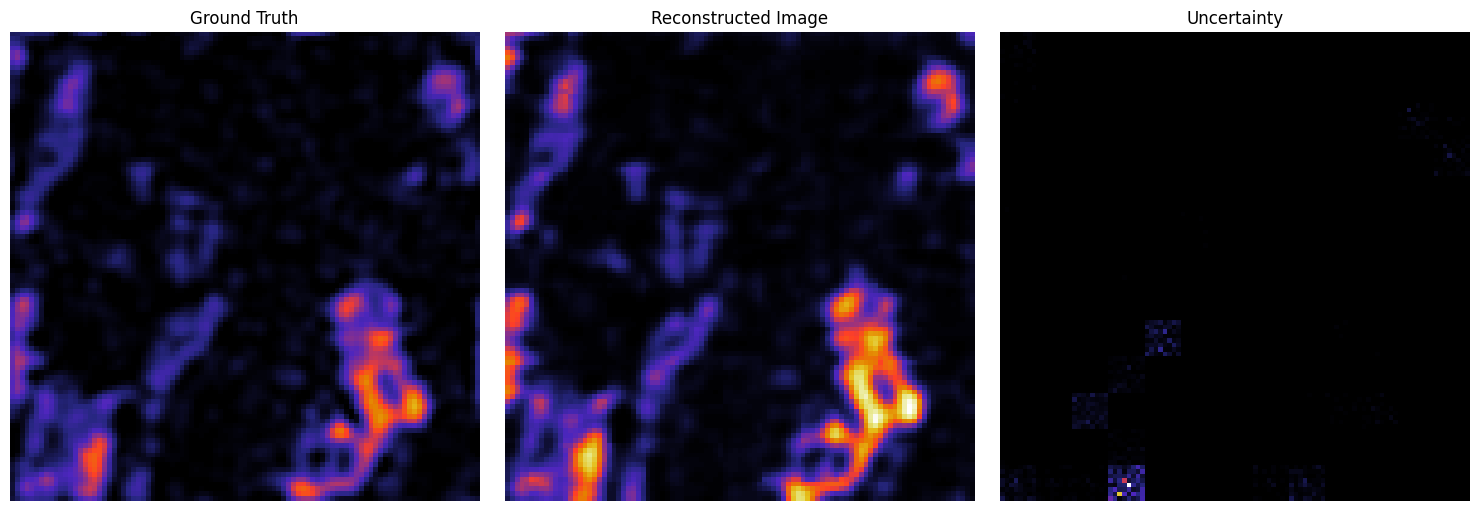

In [26]:
import matplotlib.pyplot as plt

def plot_reconstructed_image_with_uncertainty_and_ground_truth(reconstructed_img, uncertainty, ground_truth, channel_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ground_truth[channel_idx], cmap='CMRmap', vmin=0, vmax=1)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed_img[channel_idx], cmap='CMRmap')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    
    uncertainty_min = uncertainty[channel_idx].min()
    uncertainty_max = uncertainty[channel_idx].max()
    axes[2].imshow(uncertainty[channel_idx], cmap='CMRmap', vmin=uncertainty_min, vmax=uncertainty_max)
    axes[2].set_title('Uncertainty')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
plot_reconstructed_image_with_uncertainty_and_ground_truth(reconstructed_img, uncertainty, crop, channel_idx=3)